EUROSAT_MS first notebook

In [201]:
# import first librairies

import torch
import torch.nn as nn
import pandas as pd
import numpy as np
import rasterio as rs 
import matplotlib.pyplot as plt 
import pathlib
import os
import torchvision
from PIL import Image

from torchgeo import datasets, datamodules, transforms

from torch.utils.data import DataLoader, dataset
import random
import shutil
import torchgeo
from tqdm.auto import tqdm

In [202]:
subset_var = 0.2 #we will only use 20% of the dataset to begin with 

train_set_var = 0.8

source_folder = "original_dataset"
source_path = pathlib.Path(source_folder)
new_folder = "subset"
new_path = pathlib.Path(new_folder)
train_path = new_path/'train'
test_path = new_path/'test'

train_path.mkdir(exist_ok=True)
test_path.mkdir(exist_ok=True)

for classes in source_path.iterdir():
    images = list(classes.iterdir()) 
    random.shuffle(images)
    subset = images[:int(subset_var*len(images))]
    print(f"[INFO], creating subset for {classes}, with new len: {len(subset)}, and original len: {len(images)}")
    train_images = subset[:int(train_set_var*len(subset))]
    test_images = subset[int(train_set_var*len(subset)):]
    print(f"[INFO], Train set has len {len(train_images)} and Test set has len {len(test_images)}")
    train_class_dir = train_path/(classes.name)
    test_class_dir = test_path/(classes.name)
    train_class_dir.mkdir(parents=True, exist_ok=True)
    test_class_dir.mkdir(parents=True, exist_ok=True)
    for image in train_images:
        shutil.copy2(image, train_class_dir)
    for image in test_images:
        shutil.copy2(image, test_class_dir)



[INFO], creating subset for original_dataset\AnnualCrop, with new len: 600, and original len: 3000
[INFO], Train set has len 480 and Test set has len 120
[INFO], creating subset for original_dataset\Forest, with new len: 600, and original len: 3000
[INFO], Train set has len 480 and Test set has len 120
[INFO], creating subset for original_dataset\HerbaceousVegetation, with new len: 600, and original len: 3000
[INFO], Train set has len 480 and Test set has len 120
[INFO], creating subset for original_dataset\Highway, with new len: 500, and original len: 2500
[INFO], Train set has len 400 and Test set has len 100
[INFO], creating subset for original_dataset\Industrial, with new len: 500, and original len: 2500
[INFO], Train set has len 400 and Test set has len 100
[INFO], creating subset for original_dataset\Pasture, with new len: 400, and original len: 2000
[INFO], Train set has len 320 and Test set has len 80
[INFO], creating subset for original_dataset\PermanentCrop, with new len: 500

['AnnualCrop', 'Forest', 'HerbaceousVegetation', 'Highway', 'Industrial', 'Pasture', 'PermanentCrop', 'Residential', 'River', 'SeaLake']


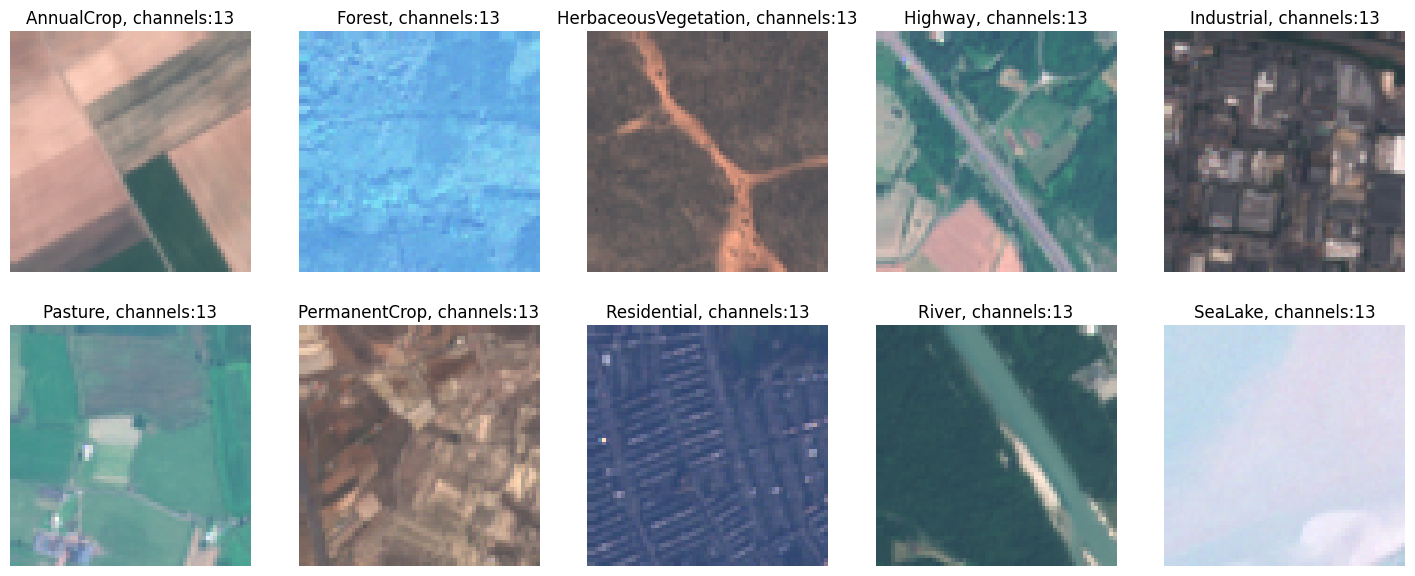

In [203]:
#We will plot one image per class
fig = plt.figure(figsize=(18,7))
class_list = []
for k, classes in enumerate(train_path.iterdir()):
    images = list(classes.iterdir())
    img = random.choice(images)
    src = rs.open(img)
    rgb = np.dstack([src.read(4),src.read(3),src.read(2)]) #stacks rgb
    count = src.count
    class_list.append(classes.name)
    plt.subplot(2,5,k+1)
    plt.axis('Off')
    plt.title(f"{classes.name}, channels:{count}")
    plt.imshow(rgb/rgb.max()) #normalize values

print(class_list)

In [204]:
class CustomDataset(dataset.Dataset):
    def __init__(self, 
                 path, 
                 transform=None, 
                 red_index=3, 
                 nir_index=7):
        super().__init__()
        self.sample = []
        self.path = path
        self.transform=transform
        self.nir_index = nir_index
        self.red_index = red_index
        root = pathlib.Path(self.path)
        for k, classes in enumerate(root.iterdir()):
            for image in list(classes.iterdir()):
                
                self.class_name = k
                self.image = image
                self.sample.append({'image':self.image, 'label':self.class_name})



    def __len__(self):
        return(len(self.sample))

    def __getitem__(self, index):
        epsilon = 1e-12
        self.image = self.sample[index]['image']
        self.class_name = self.sample[index]['label']
        with rs.open(self.image) as src:
            arr = src.read()
            arr = arr.astype(np.float32)
            arr = arr/np.max(arr)
        if self.transform is not None:
            arr = self.transform(arr)
        nir = arr[self.nir_index]
        red = arr[self.red_index]
        nvid = (nir-red)/(nir+red+epsilon)
        nvid = nvid[np.newaxis,:]
        new_arr = np.concatenate([arr,nvid])
        tens = torch.from_numpy(new_arr)
        return (tens, self.class_name)

In [205]:
first_train_dataset = CustomDataset(train_path)
first_test_dataset = CustomDataset(test_path)
first_train_dataloader = DataLoader(first_train_dataset, batch_size=32, shuffle=True)
first_test_dataloader = DataLoader(first_test_dataset, batch_size=32, shuffle=True)

In [206]:
class TinyVGG(nn.Module):
    def __init__(self, input_shape: int, hidden_units: int, output_shape: int) -> None:
        super().__init__()
        self.conv_block_1 = nn.Sequential(
            nn.Conv2d(in_channels=input_shape, 
                      out_channels=hidden_units, 
                      kernel_size=3, # how big is the square that's going over the image?
                      stride=1, # default
                      padding=1), # options = "valid" (no padding) or "same" (output has same shape as input) or int for specific number 
            nn.ReLU(),
            nn.Conv2d(in_channels=hidden_units, 
                      out_channels=hidden_units,
                      kernel_size=3,
                      stride=1,
                      padding=1),
            nn.ReLU(),
            nn.MaxPool2d(kernel_size=2,
                         stride=2) # default stride value is same as kernel_size
        )
        self.conv_block_2 = nn.Sequential(
            nn.Conv2d(hidden_units, hidden_units, kernel_size=3, padding=1),
            nn.ReLU(),
            nn.Conv2d(hidden_units, hidden_units, kernel_size=3, padding=1),
            nn.ReLU(),
            nn.MaxPool2d(2)
        )
        self.classifier = nn.Sequential(
            nn.Flatten(),
            # Where did this in_features shape come from? 
            # It's because each layer of our network compresses and changes the shape of our input data.
            nn.Linear(in_features=hidden_units*16*16,
                      out_features=output_shape)
        )
    
    def forward(self, x: torch.Tensor):
        x = self.conv_block_1(x)
        # print(x.shape)
        x = self.conv_block_2(x)
        # print(x.shape)
        x = self.classifier(x)
        # print(x.shape)
        return x

In [207]:
from torchinfo import summary
model_tinyVGG = TinyVGG(
    input_shape=14,
    hidden_units=20,
    output_shape=10
)

summary(model_tinyVGG,input_size=(32,14,64,64))

Layer (type:depth-idx)                   Output Shape              Param #
TinyVGG                                  [32, 10]                  --
├─Sequential: 1-1                        [32, 20, 32, 32]          --
│    └─Conv2d: 2-1                       [32, 20, 64, 64]          2,540
│    └─ReLU: 2-2                         [32, 20, 64, 64]          --
│    └─Conv2d: 2-3                       [32, 20, 64, 64]          3,620
│    └─ReLU: 2-4                         [32, 20, 64, 64]          --
│    └─MaxPool2d: 2-5                    [32, 20, 32, 32]          --
├─Sequential: 1-2                        [32, 20, 16, 16]          --
│    └─Conv2d: 2-6                       [32, 20, 32, 32]          3,620
│    └─ReLU: 2-7                         [32, 20, 32, 32]          --
│    └─Conv2d: 2-8                       [32, 20, 32, 32]          3,620
│    └─ReLU: 2-9                         [32, 20, 32, 32]          --
│    └─MaxPool2d: 2-10                   [32, 20, 16, 16]          --
├─S

In [210]:
def train_step(model: torch.nn.Module,
               dataloader: torch.utils.data.DataLoader,
               loss_fn: torch.nn.Module,
               optimizer: torch.optim.Optimizer):
  
  # Put the model in train mode
  model.train()

  # Setup train loss and train accuracy values
  train_loss, train_acc = 0, 0

  # Loop through data loader and data batches

  for mini_batch, data in enumerate(dataloader):
    image, label = data
    # Send data to target device
    image.to(device)
    label.to(device)

    # 1. Forward pass
    
    output = model(image)

    # 2. Calculate and accumulate loss
    
    loss = loss_fn(output, label)

    # 3. Optimizer zero grad 
    
    optimizer.zero_grad()

    # 4. Loss backward 
    
    loss.backward()

    # 5. Optimizer step
    
    optimizer.step()

    # Calculate and accumualte accuracy metric across all batches
    y_pred_class = torch.argmax(torch.softmax(output, dim=1), dim=1)
    train_loss += loss.item()
    train_acc += (y_pred_class == label).sum().item()/len(y_pred_class)

  # Adjust metrics to get average loss and average accuracy per batch

  train_loss = train_loss/len(dataloader)
  train_acc = train_acc/len(dataloader)
  return(train_loss, train_acc)
  

def test_step(model: torch.nn.Module,
              dataloader: torch.utils.data.DataLoader,
              loss_fn: torch.nn.Module):
  
  # Put model in eval mode
  model.eval()

  # Setup the test loss and test accuracy values
  test_loss, test_acc = 0, 0

  # Turn on inference context manager

  with torch.inference_mode():
  
    # Loop through DataLoader batches
    
    for mini_batch, (image, label) in enumerate(dataloader):
      # Send data to target device
      
      image.to(device)
      label.to(device)

      # 1. Forward pass
      
      output = model(image)

      # 2. Calculuate and accumulate loss

      loss = loss_fn(output, label)
      test_loss += loss.item()

      # Calculate and accumulate accuracy

      y_pred_test = torch.argmax(torch.softmax(output, dim=1), dim=1)
      test_acc += (y_pred_test==label).sum().item()/len(y_pred_test)
          
  # Adjust metrics to get average loss and accuracy per batch

    test_loss = test_loss/(len(dataloader))
    test_acc = test_acc/(len(dataloader))
    return(test_loss, test_acc)
    

def train(model: torch.nn.Module,
          train_dataloader: torch.utils.data.DataLoader,
          test_dataloader: torch.utils.data.DataLoader,
          optimizer: torch.optim.Optimizer,
          loss_fn: torch.nn.Module = nn.CrossEntropyLoss(),
          epochs: int = 5):
  
  # Create results dictionary
  results = {"train_loss": [],
             "train_acc": [],
             "test_loss": [],
             "test_acc": []}

  # Loop through the training and testing steps for a number of epochs
  for epoch in tqdm(range(epochs)):
    # Train step
    train_loss, train_acc = train_step(model=model, 
                                       dataloader=train_dataloader,
                                       loss_fn=loss_fn,
                                       optimizer=optimizer)
    # Test step
    test_loss, test_acc = test_step(model=model, 
                                    dataloader=test_dataloader,
                                    loss_fn=loss_fn)
    
    # Print out what's happening
    print(f"Epoch: {epoch+1} | "
          f"train_loss: {train_loss:.4f} | "
          f"train_acc: {train_acc:.4f} | "
          f"test_loss: {test_loss:.4f} | "
          f"test_acc: {test_acc:.4f}"
    )

    # Update the results dictionary
    results["train_loss"].append(train_loss)
    results["train_acc"].append(train_acc)
    results["test_loss"].append(test_loss)
    results["test_acc"].append(test_acc)

  # Return the results dictionary
  return results


In [211]:
loss_fn = nn.CrossEntropyLoss()
optimizer = torch.optim.Adam(model_tinyVGG.parameters(), lr = 0.01)
device = 'cpu'

In [212]:
image, label = next(iter(first_train_dataloader))
print(torch.argmax(torch.softmax(model_tinyVGG(image), dim=1), dim=1), label)

tensor([9, 9, 9, 9, 9, 9, 9, 9, 9, 9, 9, 9, 9, 9, 9, 9, 9, 9, 9, 9, 9, 9, 9, 9,
        9, 9, 9, 9, 9, 9, 9, 9]) tensor([2, 6, 1, 7, 0, 7, 7, 8, 5, 2, 1, 4, 6, 9, 8, 4, 4, 8, 2, 3, 2, 3, 1, 9,
        6, 4, 8, 5, 2, 2, 1, 6])


In [213]:
model_perf = train(
    model=model_tinyVGG,
    train_dataloader=first_train_dataloader,
    test_dataloader=first_test_dataloader,
    optimizer=optimizer,
    loss_fn=loss_fn,
    epochs=7
)


  0%|          | 0/7 [00:00<?, ?it/s]

Epoch: 1 | train_loss: 1.4712 | train_acc: 0.4427 | test_loss: 1.2177 | test_acc: 0.5190
Epoch: 2 | train_loss: 1.0318 | train_acc: 0.6280 | test_loss: 0.9885 | test_acc: 0.6614
Epoch: 3 | train_loss: 0.8939 | train_acc: 0.6810 | test_loss: 0.8935 | test_acc: 0.6547
Epoch: 4 | train_loss: 0.7455 | train_acc: 0.7404 | test_loss: 1.0114 | test_acc: 0.6433
Epoch: 5 | train_loss: 0.7032 | train_acc: 0.7508 | test_loss: 0.7377 | test_acc: 0.7294
Epoch: 6 | train_loss: 0.7045 | train_acc: 0.7516 | test_loss: 0.6623 | test_acc: 0.7662
Epoch: 7 | train_loss: 0.6170 | train_acc: 0.7851 | test_loss: 0.5799 | test_acc: 0.8170


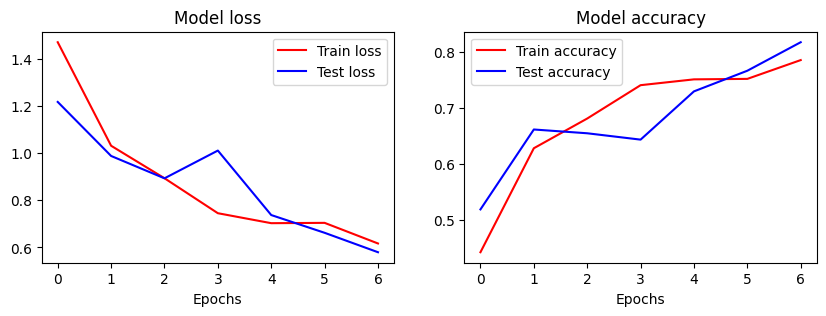

In [218]:
def plot_model_performance(dict):
    fig = plt.figure(figsize=(10,3))
    plt.subplot(1,2,1)
    plt.title('Model loss')
    plt.plot(dict["train_loss"], c='r', label='Train loss')
    plt.plot(dict["test_loss"], c='b', label='Test loss')
    plt.xlabel('Epochs')
    plt.legend()
    plt.subplot(1,2,2)
    plt.title('Model accuracy')
    plt.plot(dict["train_acc"], c='r', label='Train accuracy')
    plt.plot(dict["test_acc"], c='b', label='Test accuracy')
    plt.xlabel('Epochs')
    plt.legend()

plot_model_performance(model_perf)

In [ ]:
wrong_pred_count = 0 
for image, label in enumerate(first_test_dataset):
    while wrong_pred_count < 7:
        fig = plt.figure(figsize=(18,7))
        with torch.inference_mode():
            output = model_tinyVGG(image.unsqueeze(dim=1))

        class_list = []
        for k, classes in enumerate(train_path.iterdir()):
            images = list(classes.iterdir())
            img = random.choice(images)
            src = rs.open(img)
            rgb = np.dstack([src.read(4),src.read(3),src.read(2)]) #stacks rgb
            count = src.count
            class_list.append(classes.name)
            plt.subplot(2,5,k+1)
            plt.axis('Off')
            plt.title(f"{classes.name}, channels:{count}")
            plt.imshow(rgb/rgb.max()) #normalize values
